<a href="https://colab.research.google.com/github/vujjiniashrith/Generative_Adverserial_Network-MNIST-Fashion-/blob/main/GAN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all the dependencies

In [ ]:
import tensorflow as tf
from matplotlib import pyplot as plt

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
ds = tfds.load('fashion_mnist',split = 'train')

In [ ]:
type(ds)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [ ]:
ds.as_numpy_iterator().next()['label']

2

# Visulaizing the data

In [ ]:
import numpy as np
# to do some data transformation

In [ ]:
dataiterator = ds.as_numpy_iterator()

In [ ]:
#getting data out of a pipeline
dataiterator.next()['image'].shape

(28, 28, 1)

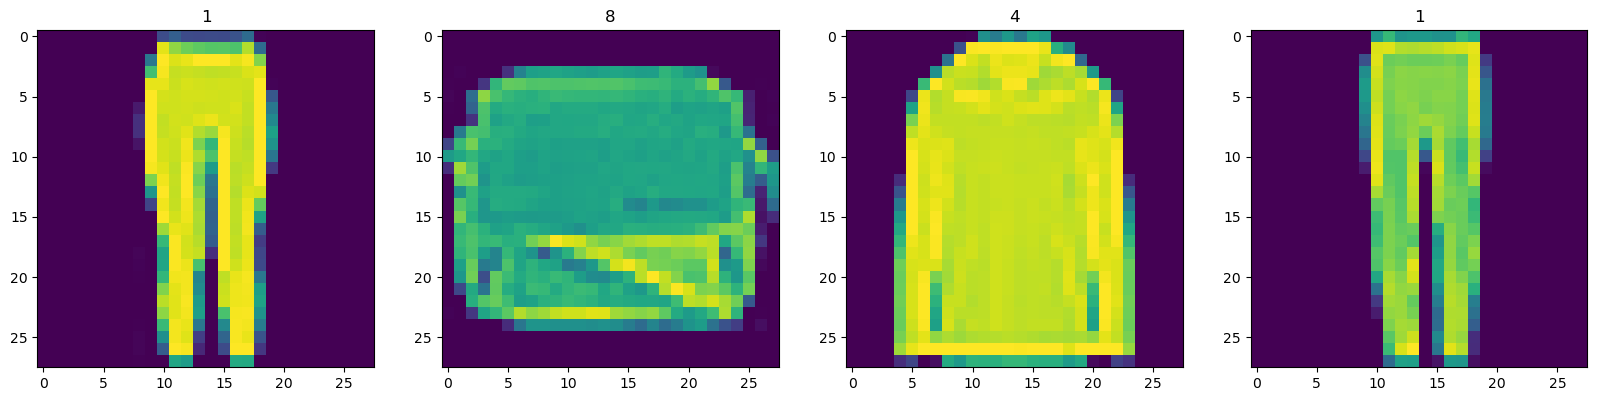

In [ ]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx in range(4):
    #grab an image from the pipeline
    batch = dataiterator.next()
    ax[idx].imshow(np.squeeze(batch['image']))
    ax[idx].title.set_text(batch['label'])

In [ ]:
ax

array([<AxesSubplot:title={'center':'1'}>,
       <AxesSubplot:title={'center':'8'}>,
       <AxesSubplot:title={'center':'4'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

In [ ]:
def scale_images(data):
    image = data['image']
    return image/255

In [ ]:
ds = tfds.load('fashion_mnist',split='train')
ds = ds.map(scale_images)#running the dataset through the scale_images preprocessing step
ds = ds.cache()#cache the dataset for that batch
ds = ds.shuffle(60000)#shuffling the dataset
ds = ds.batch(128)#we are batching into 128 images per sample
ds = ds.prefetch(64)# reduces the bottlenecking

In [ ]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# Build Neural Network

In [ ]:
# import modelling components
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout
#used for generator to upsample the images to add little bit more depth
from tensorflow.keras.layers import UpSampling2D

***Build Generator***

In [ ]:
def build_generator():
    model = Sequential()

    # we are giving 128 random inputs list to generate an image normally called as LatentSpace
    #takes in random values and reshapes it to 7x7x128
    model.add(Dense(7*7*128, input_dim = 128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))#outputiing the data

    #Upsampling block 1
    model.add(UpSampling2D())#effectively doubles the each row and column
    model.add(Conv2D(128,5,padding = 'same'))# total 128 filters with shape 5x5
    model.add(LeakyReLU(0.2))

    #Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128,5,padding='same'))
    model.add(LeakyReLU(0.2))

    #Convlutional bloc 1
    model.add(Conv2D(128,4,padding='same'))
    model.add(LeakyReLU(0.2))

    #Convloutional bloc 2
    model.add(Conv2D(128,4,padding='same'))
    model.add(LeakyReLU(0.2))

    #Conv Layer to get to one channel
    model.add(Conv2D(1,4,padding = 'same', activation = 'sigmoid'))



    return model

In [ ]:
generator = build_generator()

In [ ]:
generator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_5 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_9 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [ ]:
imgs = generator.predict(np.random.randn(4,128,1))

In [ ]:
img.shape

(28, 28, 1)

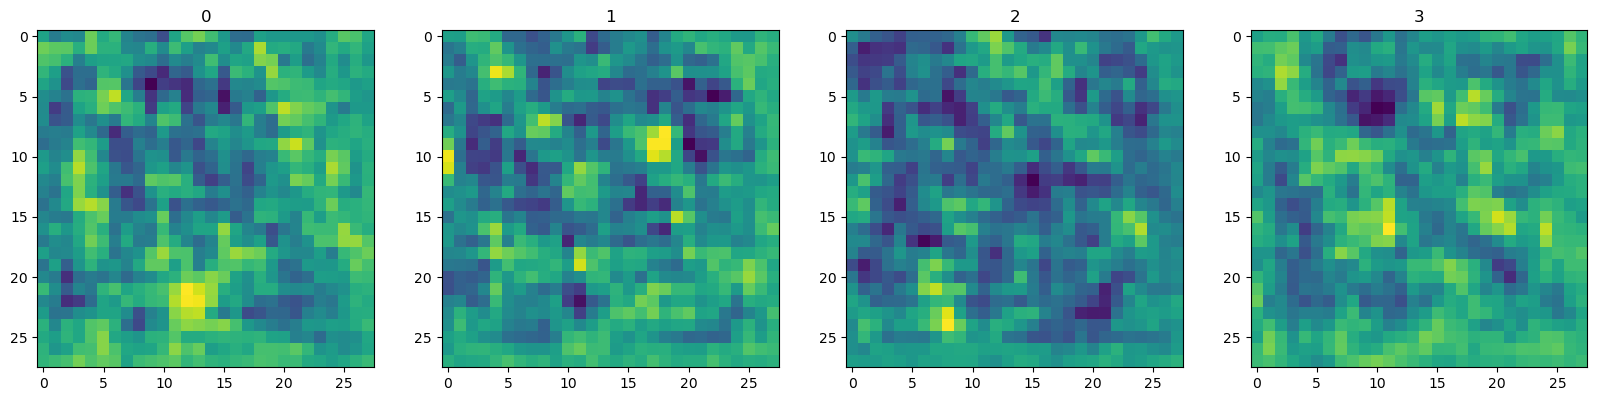

In [ ]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx,img in enumerate(imgs):
    #grab an image from the pipeline
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

***Build Discriminator***

In [ ]:
def build_discriminator():
    model = Sequential()

    #first conv block
    model.add(Conv2D(32,5,input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #second conv block
    model.add(Conv2D(64,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #third conv block
    model.add(Conv2D(128,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #Fourth conv block
    model.add(Conv2D(256,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #Flatten and then pass through Dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1,activation = 'sigmoid'))

    return model

In [ ]:
discriminator = build_discriminator()

In [ ]:
discriminator.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_47 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_26 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_44 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_48 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_27 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_45 (Conv2D)          (None, 16, 16, 128)     

In [ ]:
imgs.shape

(4, 28, 28, 1)

In [ ]:
discriminator.predict(imgs)

array([[0.49665552],
       [0.4968609 ],
       [0.49675632],
       [0.49670282]], dtype=float32)

# Building a custom Training loop

***Setup Losses and Optimizers***

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
g_opt = Adam(learning_rate = 0.0001)
d_opt = Adam(learning_rate = 0.00001)

In [ ]:
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

***Build Subclassed Model***

In [ ]:
from tensorflow.keras.models import Model #importing the base model class to subclass of out training step

In [ ]:
class FashionGAN(Model):
    def __init__(self, generator,discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)

        #create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        #compile with the base class
        super().compile(*args, **kwargs)

        #create attribute for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self,batch):
        #get the data
        real_images = batch # getting the real data
        fake_images = self.generator(tf.random.normal((128,128,1)),training = False)

        #train the discriminator
        with tf.GradientTape() as d_tape:

            #pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images , training = True)
            yhat_fake = self.discriminator(fake_images, training = True)
            yhat_realfake = tf.concat([yhat_real,yhat_fake],axis = 0)

            #Create labels for real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real),tf.ones_like(yhat_fake)],axis=0)

            #add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real,noise_fake],axis=0)

            #calculate loss
            total_d_loss = self.d_loss(y_realfake,yhat_realfake)

        #Apply backpropogation - nn learn
        dgrad = d_tape.gradient(total_d_loss,self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad,self.discriminator.trainable_variables))

        #train the generator
        with tf.GradientTape() as g_tape:
            #Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training = True)

            #Create the predicted labels
            predicted_labels = self.discriminator(gen_images,training = False)

            #calculate loss
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels),predicted_labels)

        #apply backpropogation
        ggrad = g_tape.gradient(total_g_loss,self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad,self.generator.trainable_variables))

        return {"d_loss" : total_d_loss, "g_loss": total_g_loss}





In [ ]:
fashgan = FashionGAN(generator,discriminator)

In [ ]:
fashgan.compile(g_opt,d_opt,g_loss,d_loss)

***Build Callback***

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [ ]:
class ModelMonitor(Callback):
    #latent dimension is the dimension that we are giving to the genrator to generate image
    def __init__(self, num_img = 3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('Images',f'generated_img_{epoch}_{i}.png'))

***Train***

In [ ]:
hist = fashgan.fit(ds,epochs= 20, callbacks = [ModelMonitor()])

Epoch 1/20
 12/469 [..............................] - ETA: 1:06:51 - d_loss: 0.6930 - g_loss: 0.6873

KeyboardInterrupt: 

In [ ]:
cpus = tf.config.experimental.list_physical_devices('CPU')

In [ ]:
cpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

***Review Performance***

In [ ]:
hist.history

NameError: name 'hist' is not defined